In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

In [3]:
# filepath to data file 
file_path = "shrunk_output.csv"

# converted the CSV file to a DataFrame
df = pd.read_csv(file_path)
# display the first few rows of the DataFrame
print(df.head())

   searchDate  flightDate startingAirport destinationAirport  isBasicEconomy  \
0  2022-08-26  2022-08-30             ATL                LAX           False   
1  2022-09-27  2022-10-08             SFO                EWR           False   
2  2022-06-29  2022-08-04             OAK                SFO           False   
3  2022-05-26  2022-06-24             EWR                DEN           False   
4  2022-04-17  2022-06-05             LAX                PHL           False   

   isNonStop  baseFare  totalFare  
0      False    305.12     350.10  
1      False    385.12     437.60  
2      False    333.03     387.21  
3       True    459.53     508.60  
4      False    730.23     808.60  


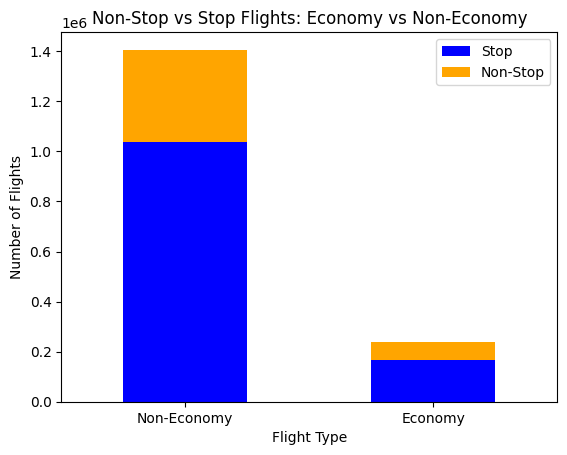

In [4]:
# get data to plot
non_stop_counts = df.groupby(['isBasicEconomy', 'isNonStop']).size().unstack()

# create bar plot for flight type comparison
non_stop_counts.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Non-Stop vs Stop Flights: Economy vs Non-Economy')
plt.xticks(ticks=[0, 1], labels=['Non-Economy', 'Economy'], rotation=0)
plt.xlabel('Flight Type')
plt.ylabel('Number of Flights')
plt.legend(['Stop', 'Non-Stop'])
plt.show()

C:\Users\mkaje\AppData\Local\Temp\ipykernel_26152\2094142260.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='isBasicEconomy', y='totalFare', palette='coolwarm')


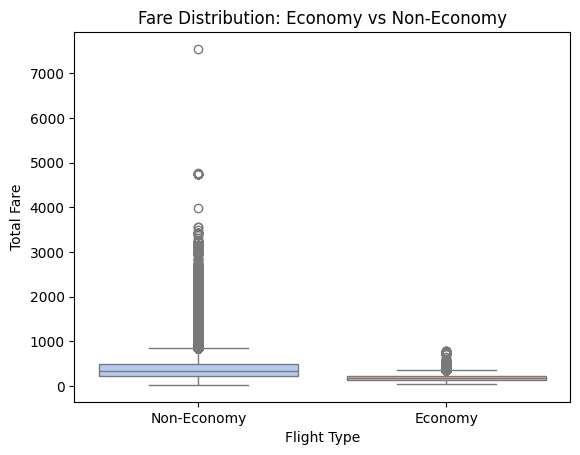

In [5]:
# create a histogram plot for economy vs. non-economy
sns.boxplot(data=df, x='isBasicEconomy', y='totalFare', palette='coolwarm')
plt.xticks(ticks=[0, 1], labels=['Non-Economy', 'Economy'])
plt.title('Fare Distribution: Economy vs Non-Economy')
plt.xlabel('Flight Type')
plt.ylabel('Total Fare')
plt.show()

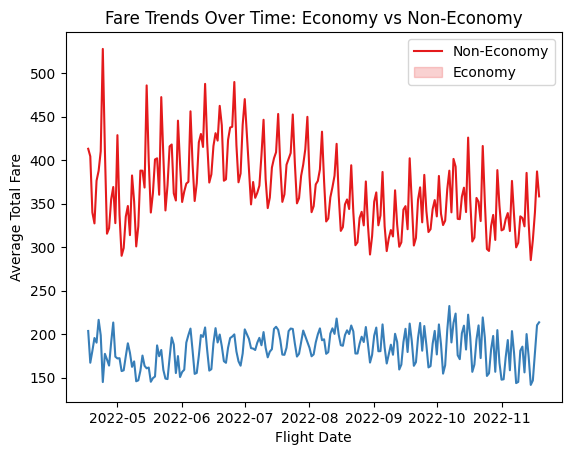

In [6]:
# get the average fares
df['flightDate'] = pd.to_datetime(df['flightDate'])
avg_fare = df.groupby(['flightDate', 'isBasicEconomy'])['totalFare'].mean().reset_index()

# create a line plot
sns.lineplot(data=avg_fare, x='flightDate', y='totalFare', hue='isBasicEconomy', palette='Set1')
plt.title('Fare Trends Over Time: Economy vs Non-Economy')
plt.xlabel('Flight Date')
plt.ylabel('Average Total Fare')
plt.legend(['Non-Economy', 'Economy'])
plt.show()


C:\Users\mkaje\AppData\Local\Temp\ipykernel_26152\2553229914.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=destination_counts.index, y=destination_counts.values, palette='viridis')


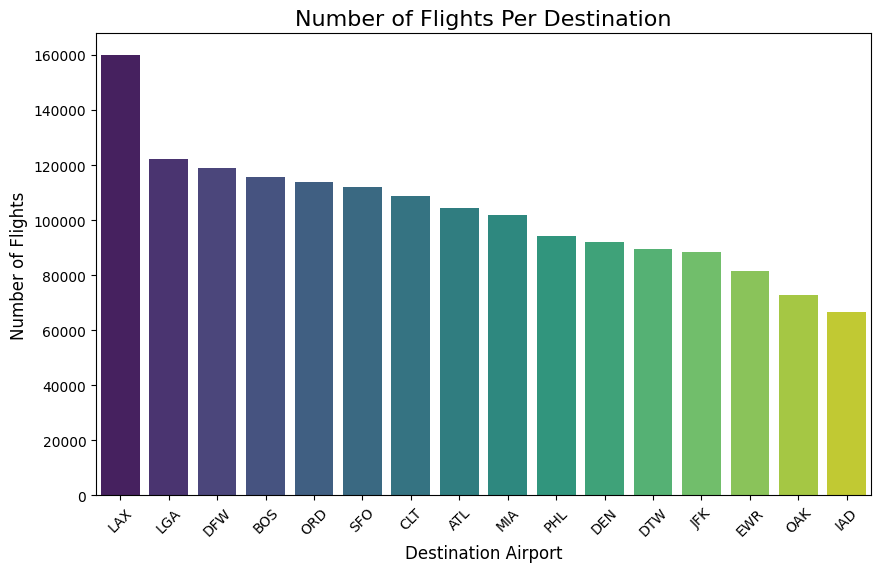

In [7]:
# count the number of flights per destination
destination_counts = df['destinationAirport'].value_counts()

# plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=destination_counts.index, y=destination_counts.values, palette='viridis')
plt.title('Number of Flights Per Destination', fontsize=16)
plt.xlabel('Destination Airport', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [8]:
df = df[(df['isBasicEconomy'] == True)]
avg_price = df["totalFare"].mean()

df["searchDate"] = pd.to_datetime(df["searchDate"], errors="coerce")
df["flightDate"] = pd.to_datetime(df["flightDate"], errors="coerce")

df["dateDifference"] = (df["flightDate"] - df["searchDate"]).dt.days

avg_day_difference = df["dateDifference"].mean()

print(avg_price, avg_day_difference)
print(df)

df["priceClassification"] = df.apply(lambda row: 0 if row['totalFare'] > avg_price * 1.05 or row['dateDifference'] > avg_day_difference * 1.1 else 1, axis=1)

print(df["priceClassification"].value_counts())

178.9490167916359 28.53885309958813
        searchDate flightDate startingAirport destinationAirport  \
19      2022-04-29 2022-06-15             LGA                MIA   
36      2022-07-12 2022-08-24             EWR                LAX   
38      2022-09-02 2022-09-08             BOS                DEN   
42      2022-08-11 2022-08-18             LGA                ORD   
62      2022-09-13 2022-10-18             CLT                JFK   
...            ...        ...             ...                ...   
1642721 2022-08-10 2022-09-10             IAD                MIA   
1642745 2022-08-12 2022-09-17             LAX                DFW   
1642746 2022-09-10 2022-09-23             LAX                EWR   
1642763 2022-07-30 2022-09-12             JFK                PHL   
1642767 2022-08-14 2022-08-30             CLT                SFO   

         isBasicEconomy  isNonStop  baseFare  totalFare  dateDifference  
19                 True       True     75.35      95.60              47  

In [14]:
# baseline model - Logistic Regression

# set up X and y
X = df[["startingAirport", "destinationAirport", "totalFare", "dateDifference"]]
y = df[["priceClassification"]]

encoded_X = pd.get_dummies(X, columns=["startingAirport", "destinationAirport"], drop_first=True) 

# split X and y into training and testing data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)

# train baseline model
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
p_hat = model.predict_proba(X_test.values)

# Log Loss
log_loss = metrics.log_loss(y_true = y_test, y_pred = p_hat)
print(f"Logistic Regression Log Loss: {log_loss}")

# Accuracy Score
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")

# Precision Score
precision = metrics.precision_score(y_test, y_pred)
print(f"Logistic Regression Precision: {precision}")

# Recall Score
recall = metrics.recall_score(y_test, y_pred)
print(f"Logistic Regression Recall: {recall}")

# Kappa Score
kappa = metrics.cohen_kappa_score(y_test, y_pred)
print(f"Logistic Regression Kappa: {kappa}")

# f1 Score
f1 = metrics.f1_score(y_test, y_pred)
print(f"Logistic Regression f1 score: {kappa}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Log Loss: 0.2808454377257033
Logistic Regression Accuracy: 0.8636181222938009
Logistic Regression Precision: 0.8047079337401918
Logistic Regression Recall: 0.7719377251672671
Logistic Regression Kappa: 0.6875247482644322
Logistic Regression f1 score: 0.6875247482644322


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [15]:
# XGBoost model

# prepare the X and y data
X = df[["startingAirport", "destinationAirport", "totalFare", "dateDifference"]]
y = df["priceClassification"]

# encode categorical variables
encoded_X = pd.get_dummies(X, columns=["startingAirport", "destinationAirport"], drop_first=True)

# split the data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)

# set up and train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)
p_hat = model.predict_proba(X_test)

# calculate metrics
log_loss = metrics.log_loss(y_test, p_hat)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='binary')
recall = metrics.recall_score(y_test, y_pred, average='binary')
kappa = metrics.cohen_kappa_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

# output the results
print(f"XGBoost Log Loss: {log_loss}")
print(f"XGBoost Accuracy: {accuracy}")
print(f"XGBoost Precision: {precision}")
print(f"XGBoost Recall: {recall}")
print(f"XGBoost Kappa: {kappa}")
print(f"XGBoost f1 Score: {f1_score}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Log Loss: 0.0010516095900189573
XGBoost Accuracy: 0.999746541345443
XGBoost Precision: 0.9994212218649517
XGBoost Recall: 0.9998069994853319
XGBoost Kappa: 0.9994253823524982
XGBoost f1 Score: 0.9996140734546858


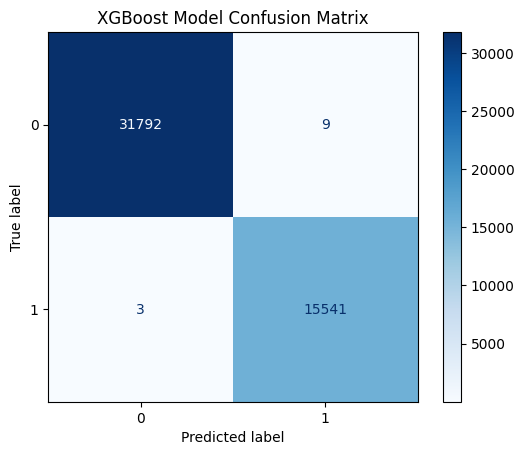

In [11]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Model Confusion Matrix')
plt.show()

In [19]:
# Gaussian Naive Bayes model

X = df[["startingAirport", "destinationAirport", "totalFare", "dateDifference"]].copy()  # Ensure this is a copy
y = df["priceClassification"].copy()  # Ensure this is a copy

# encode categorical variables if they are not numeric
encoder = LabelEncoder()
X.loc[:, 'startingAirport'] = encoder.fit_transform(X['startingAirport'])
X.loc[:, 'destinationAirport'] = encoder.fit_transform(X['destinationAirport'])

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# set up and train the Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

# get predictions on the test set
y_pred = model.predict(X_test)
p_hat = model.predict_proba(X_test)  # Get probability estimates for the log_loss calculation

# calculate stats
log_loss_value = metrics.log_loss(y_test, p_hat)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='binary')
recall = metrics.recall_score(y_test, y_pred, average='binary')
kappa = metrics.cohen_kappa_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

# print stats
print(f"GNB model Log Loss: {log_loss_value}")
print(f"GNB model Accuracy: {accuracy}")
print(f"GNB model Precision: {precision}")
print(f"GNB model Recall: {recall}")
print(f"GNB model Kappa: {kappa}")
print(f"GNB f1 Score: {f1_score}")

GNB model Log Loss: 0.2050811347722352
GNB model Accuracy: 0.9463934945611997
GNB model Precision: 0.9884332281808622
GNB model Recall: 0.8466289243437982
GNB model Kappa: 0.8738297034914488
GNB f1 Score: 0.9120521172638436


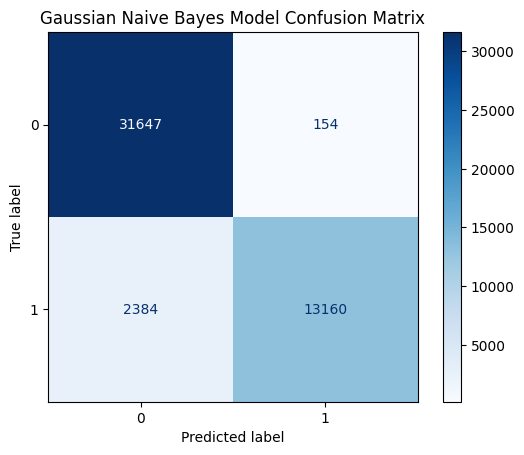

In [13]:
# display the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Gaussian Naive Bayes Model Confusion Matrix')
plt.show()